## 0. Setup

In [1]:
# Enable autoreload so edits to modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2


In [2]:
## Utils to read data

from enum import Enum
from pathlib import Path
import sys



DATA_PATH_PREFIX = Path.cwd() / "data/SAMD21_Fan_Demo-"

# go to project root
root = str(Path.cwd().parent)
sys.path.append(root)
print("Root: ", root)

class DataType(Enum):
    Normal = 1
    Blocked = 2
    Interference = 3
    OFF = 4


def get_data_path(datatype: DataType, index: int):

    if datatype == DataType.Interference:
        strcode = "Blade Interference"
    
    elif datatype == DataType.Normal:
        strcode = "Fan ON"
    
    elif datatype == DataType.Blocked:
        strcode = "Blocked Flow"
    
    elif datatype == DataType.OFF:
        strcode = "Fan OFF"
    
    postfix = strcode + f"_{index:03d}" + ".csv"
    return str(DATA_PATH_PREFIX) + postfix



Root:  /home/btanady/fourth_year/cpen491


## 1. Prepare training data

In [3]:
from fdd_system.ML.common.config.operating_types import OperatingCondition
from experiment.utils import prepare_training_data
import os
import importlib

importlib.reload

DATA_PATH = Path("data_1")



# NORMAL_FILES = [str(get_data_path(DataType.Normal, i)) for i in range(1, 5)]
# FAULTY_FILES = [str(get_data_path(DataType.Blocked, i)) for i in range(1, 4)]

normal_path = DATA_PATH / "normal"
blocked_path = DATA_PATH / "blocked"

NORMAL_FILES = [os.path.join(normal_path, f) for f in os.listdir(normal_path)]
FAULTY_FILES = [os.path.join(blocked_path, f) for f in os.listdir(blocked_path)]


training_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES
}

data = prepare_training_data(training_data, True, col_names=["X", "Y", "Z"])

## 2. Preprocessing (TODO)

In [4]:
from fdd_system.ML.common.classification.preprocessor import DummyPreprocessor, BasicPreprocessor

pre = DummyPreprocessor()
preprocessed = pre.preprocess(data)

## 3. Embedding

In [5]:
from fdd_system.ML.common.classification.embedder import MLEmbedder1

embedder = MLEmbedder1()
embeddings = embedder.embed(preprocessed)
embeddings[0]


array([ 8.93555323e+00,  9.25252593e-02,  8.93603226e+00,  4.59031007e-01,
        1.02847178e+00,  2.17878149e-02, -2.24245571e-01,  5.57765581e+02,
        6.97018634e+02,  5.16079052e+01,  1.24966233e+00,  7.34375000e+01,
        8.91788304e-01,  3.00870365e-03,  2.86037364e-01,  4.58348854e-04,
        4.35752115e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.47575616e-03,  1.52340977e-01,  5.14062500e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.01573036e-01,  7.98426964e-01,  0.00000000e+00,
        4.25531915e-02,  7.34375000e+01,  1.17500000e+01])

## 3.1 Optional PCA - observe how good are the embeddings

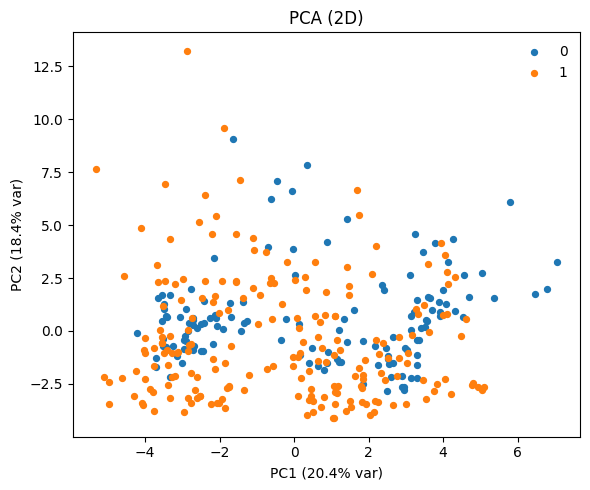

In [6]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def plot_pca_2d(embeddings, labels):
    emb_df = pd.DataFrame(embeddings)
    X = StandardScaler().fit_transform(emb_df)
    y = labels


    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(Z[:,0], Z[:,1], s=18)
    else:
        for cls in np.unique(y):
            m = (y == cls)
            plt.scatter(Z[m,0], Z[m,1], s=18, label=str(cls))
        plt.legend(frameon=False)

    evr = pca.explained_variance_ratio_
    plt.xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
    plt.title("PCA (2D)")
    plt.tight_layout()
    plt.show()


labels = [d.label for d in data]

plot_pca_2d(embeddings, labels)


## 4. Training

Best n_estimators: 95 (val acc=0.908)


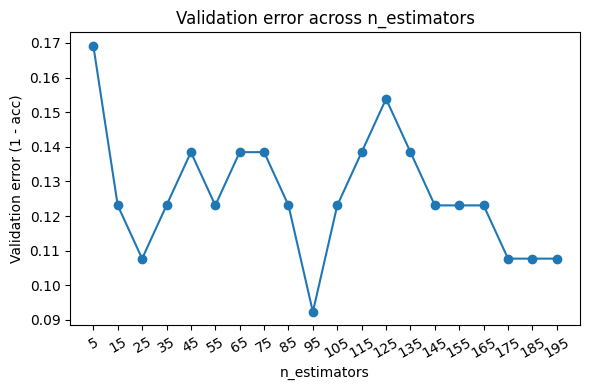

array([[31,  4],
       [ 5, 47]])

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        35
           1       0.92      0.90      0.91        52

    accuracy                           0.90        87
   macro avg       0.89      0.89      0.89        87
weighted avg       0.90      0.90      0.90        87

Number of test packets:  87
Accuracy:  0.896551724137931


['weights/rf_model.joblib']

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from joblib import dump, load
import os
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Convert list of dicts to arrays
X = np.array(embeddings)
y = np.array([d.label for d in data])

# Hold out a test set, then carve validation out of the training data for tuning
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)

n_estimators = np.arange(5, 200, 10)

best_model = None
best_score = -1.0
best_params = None
val_scores = []

for n_est in n_estimators:
    n_est = int(n_est)
    clf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_est)
    clf.fit(X_train, y_train)

    val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    val_scores.append(val_acc)

    if val_acc > best_score:
        best_score = val_acc
        best_params = n_est
        best_model = clf

print(f"Best n_estimators: {best_params} (val acc={best_score:.3f})")

# Plot validation error versus number of trees
plt.figure(figsize=(6, 4))
val_errors = 1.0 - np.array(val_scores)
plt.plot(n_estimators, val_errors, marker="o")
plt.xticks(n_estimators, rotation=30)
plt.ylabel("Validation error (1 - acc)")
plt.xlabel("n_estimators")
plt.title("Validation error across n_estimators")
plt.tight_layout()
plt.show()

# Evaluate tuned model on the untouched test set
y_pred = best_model.predict(X_test)

display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Number of test packets: ", len(y_test))
print("Accuracy: ", sum(y_test == y_pred) / len(y_test))

os.makedirs("weights", exist_ok=True)
dump(best_model, "weights/rf_model.joblib")


## 5. Extra test
Seems odd that the accuracy is too good, let me try on dataset that was never fed to the model

In [8]:
# NORMAL_FILES_2 = [str(get_data_path(DataType.Normal, i)) for i in range(5, 6)]
# FAULTY_FILES_2 = [str(get_data_path(DataType.Blocked, i)) for i in range(4, 5)]
# raw_data = {
#     OperatingCondition.NORMAL.value: NORMAL_FILES_2,
#     OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES_2
# }

# data = prepare_training_data(raw_data, True, col_names=["AccelerometerX", "AccelerometerY", "AccelerometerZ"])
# X = embedder.embed(data)
# y_true = np.array([d.label for d in data])

# clf_loaded: RandomForestClassifier = load("weights/rf_model.joblib")
# y_pred = clf_loaded.predict(X)

# print(classification_report(y_true, y_pred))
# print("Number of test packets: ", len(y_true))
# print("Accuracy: ", sum(y_true == y_pred) / len(y_true))

# plot_pca_2d(X, y_true)


## 6. Exmple of using ClassificationPipeline for inference

Q: Why do we need such Wrapper?  
Ans: It might seem "stupid" for some, but treat it as an investment. Such structuring reduces later cost of development.  
Imagine when we want to integrate with the hardware for demo, it's easier to not think much and just assemble the pipeline  
and then call pipeline.infer() to predict if a particular input is "normal" or "blocked_airflow"



In [9]:
# from fdd_system.ML.inference.classification_pipeline import ClassificationPipeline
# from fdd_system.ML.common.classification.embedder import MLEmbedder1
# from fdd_system.ML.common.classification.preprocessor import DummyPreprocessor, BasicPreprocessor
# from fdd_system.ML.common.classification.inferrer import SklearnMLInferrer


# # 1. load model
# model: RandomForestClassifier = load("weights/rf_model.joblib")

# # 2. load pipeline
# pipeline = ClassificationPipeline(
#     preprocessor=BasicPreprocessor(),
#     embedder=MLEmbedder1(),
#     inferrer=SklearnMLInferrer(model=model)
# )

# # 3. get data ready
# NORMAL_FILES_2 = [str(get_data_path(DataType.Normal, i)) for i in range(5, 6)]
# FAULTY_FILES_2 = [str(get_data_path(DataType.Blocked, i)) for i in range(4, 5)]
# raw_data = {
#     OperatingCondition.NORMAL.value: NORMAL_FILES_2,
#     OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES_2
# }
# data = prepare_training_data(raw_data, True, col_names=["AccelerometerX", "AccelerometerY", "AccelerometerZ"])
# y_true = np.array([d.label for d in data])


Note that on deployment, it is highly likely we only declare pipeline once, and reuse it over and over again  
this reduces the cost. That's why I split the code here (to measure performance more reliably)

NB: My laptop takes about 3 ms to infer a packet with WINDOW_LENGTH = 100, Sampling_rate = 400 Hz  
So it takes 3ms to process 0.25 s of data for now

In [10]:
# import time

# start = time.perf_counter()
# # 4. run inference
# y_pred = pipeline.predict(data)

# # 5. Get accuracy
# print(classification_report(y_true, y_pred))
# print("Number of test packets: ", len(data))
# print("Accuracy: ", sum(y_true == y_pred) / len(y_true))

# end = time.perf_counter()

# interval = end - start 
# time_per_packet = (interval * 1000) / len(data)
# print(f"Pipeline inference time: {time_per_packet:.2f} ms per packet")

## 7. CNN ##

**Embedding** 

we will first use STFT to transform the original data into a 2D image

TODO: nperseg, noverlap, and nfft should be automatically adjusted

ex:
nperseg, noverlap, nfft = `auto_stft_params(SensorConfig)`


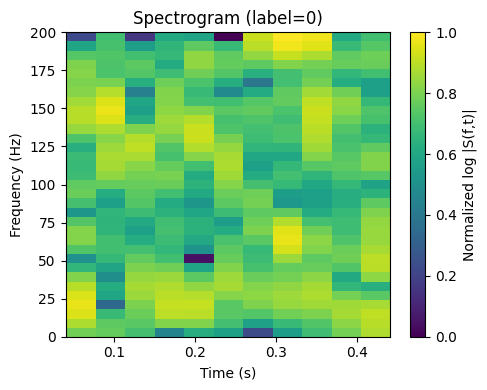

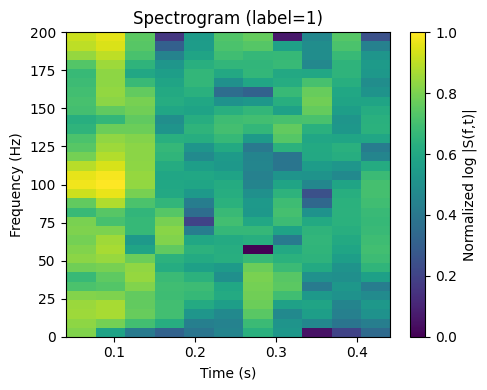

In [11]:
from fdd_system.ML.common.classification.embedder import Spectrogram2DEmbedder

embedder2d = Spectrogram2DEmbedder(
    nperseg=32, # window length (in samples) used for each STFT segment
    noverlap=16, # number of overlapped samples between consecutive segments
    nfft=64, # FFT size
)

windows = prepare_training_data(training_data, shuffle=False, col_names=["X", "Y", "Z"])

w0 = next(w for w in windows if w.label == 0)
w1 = next(w for w in windows if w.label == 1)

embedder2d.plot_spectrogram_window(w0)
embedder2d.plot_spectrogram_window(w1)


We can observe significant differences in images with different labels, indicating that this is learnable by CNN

Next, prepare a `Dataset` class for the torch API

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpectrogramDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


This CNN is reasonably small but expressive. It uses three conv blocks + adaptive pooling

$x \in \mathbb{R}^{1\times F\times T}$, F stands for freq, T stands for time

$z_1 = \gamma_1 \frac{(x * w_1) - \mu_k}{\sqrt{\sigma_1^2 + \epsilon}} + \beta_1 \in \mathbb{R}^{16 \times F\times T}$

$h_1 = Pool_{max} (ReLU(z_1)) \in \mathbb{R}^{16 \times \frac{F}{2}\times \frac{T}{2}}$

$z_2 = \gamma_2 \frac{(h_1 * w_2) - \mu_k}{\sqrt{\sigma_2^2 + \epsilon}} + \beta_2 \in \mathbb{R}^{32 \times \frac{F}{2}\times \frac{T}{2}}$

$h_2 = Pool_{max} (ReLU(z_2)) \in \mathbb{R}^{32 \times \frac{F}{4}\times \frac{T}{4}}$

$z_3 = \gamma_3 \frac{(h_2 * w_3) - \mu_k}{\sqrt{\sigma_3^2 + \epsilon}} + \beta_3 \in \mathbb{R}^{64 \times \frac{F}{4}\times \frac{T}{4}}$

$h_3 = Pool_{max} (ReLU(z_3)) \in \mathbb{R}^{64 \times \frac{F}{8}\times \frac{T}{4}}$ here, our T/4 = 1, so I cannot do futher

$h_4 = 2DAvg(h_3) \in \mathbb{R}^{64 \times 1 \times 1}$

$h_5 = Flatten(h_4) \mathbb{R}^{64}$

$h_6 = ReLU(w_6 h_5 + b_6) \in \mathbb{R}^{128 \times 64}$

$y = w_7 Dropout(h_6) + b_7 \in \mathbb{R}^{n_{class}}$

In [13]:
import torch.nn as nn

class FanSpectrogramCNN(nn.Module):
    def __init__(self, n_classes: int = 2):
        super().__init__()

        self.features = nn.Sequential(
            # (N, 1, F, T) -> (N, 16, F/2, T/2)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)), # pool both freq & time

            # (N, 16, F/2, T/2) -> (N, 32, F/4, T/4)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # (N, 32, F/4, T/4) -> (N, 64, F/8, T/4)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1)), # pool freq only, since the time dim may be small
        )

        # Global average pooling: (N, 64, H, W) -> (N, 64, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(), #(N, 64)
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_classes), # I don't use softmax here since CrossEntropyLoss does it internally, and I don't care about probabilities but only the scores
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


In [14]:
from sklearn.model_selection import train_test_split
from fdd_system.ML.common.classification.preprocessor import DummyPreprocessor

normal_path = DATA_PATH / "normal"
blocked_path = DATA_PATH / "blocked"

normal_files = sorted([os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.endswith(".csv")])
blocked_files = sorted([os.path.join(blocked_path, f) for f in os.listdir(blocked_path) if f.endswith(".csv")])

norm_train, norm_val = train_test_split(normal_files, test_size=0.4, random_state=42)
blk_train, blk_val = train_test_split(blocked_files, test_size=0.4, random_state=42)

train_files = {
    OperatingCondition.NORMAL.value: norm_train,
    OperatingCondition.BLOCKED_AIRFLOW.value: blk_train,
}

val_files = {
    OperatingCondition.NORMAL.value: norm_val,
    OperatingCondition.BLOCKED_AIRFLOW.value: blk_val,
}

# Window separately to avoid overlap leakage between train/val
train_data = prepare_training_data(train_files, shuffle=True, col_names=["X", "Y", "Z"])
val_data = prepare_training_data(val_files, shuffle=True, col_names=["X", "Y", "Z"])

pre = BasicPreprocessor()
train_pre = pre.preprocess(train_data)
val_pre = pre.preprocess(val_data)

X_train = embedder2d.embed(train_pre) # (N, 1, F, T)
y_train = np.array([d.label for d in train_pre], dtype=np.int64)
X_val = embedder2d.embed(val_pre) # (N, 1, F, T)
y_val = np.array([d.label for d in val_pre], dtype=np.int64)

train_dataset = SpectrogramDataset(X_train, y_train)
val_dataset = SpectrogramDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=False)


NOTE: This training took 2.2s on a RTX 4090 graphics card

Using device: cuda


/tmp/ipykernel_43284/2778908580.py:93: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1126 16:49:07.486000 43284 torch/onnx/_internal/exporter/_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `FanSpectrogramCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `FanSpectrogramCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
Exported ONNX model to: weights/cnn.onnx


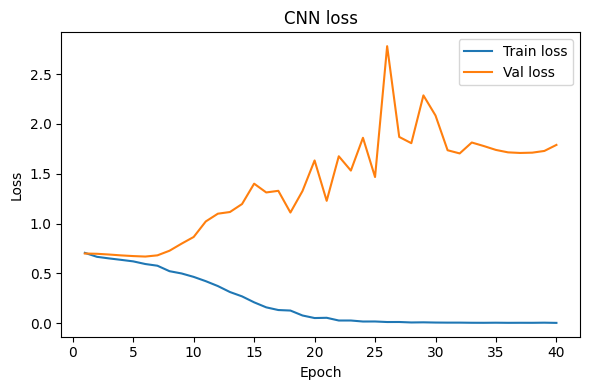

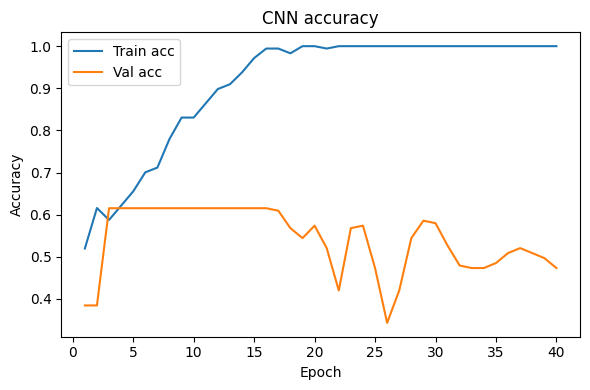

In [15]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import os
import logging
import torch.onnx

logging.getLogger("onnxscript").setLevel(logging.ERROR)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
onnx_path = "weights/cnn.onnx"

num_classes = len(np.unique(y_train))
model = FanSpectrogramCNN(n_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5*1e-3)

num_epochs = 40

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Grab a representative batch for ONNX export
example_input = next(iter(train_loader))[0].to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        _, preds = torch.max(outputs, dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # print(
    #     f"Epoch [{epoch+1:02d}/{num_epochs}] "
    #     f"Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} "
    #     f"Train Acc: {train_acc:.3f} Val Acc: {val_acc:.3f}"
    # )

# Export to ONNX using a representative input
model.eval()
os.makedirs("weights", exist_ok=True)

torch.onnx.export(
    model,
    example_input,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=18,
)
print("Exported ONNX model to:", onnx_path)

# Plot loss and accuracy curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accs, label="Train acc")
plt.plot(epochs, val_accs, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)

        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

print("Test accuracy:", val_correct / val_total)


Test accuracy: 0.47337278106508873


In [17]:
# Example: end-to-end inference on raw accelerometer window with the ONNX model
import numpy as np
from fdd_system.ML.common.config.data import RawAccWindow
from fdd_system.ML.common.classification.preprocessor import BasicPreprocessor
from fdd_system.ML.common.classification.embedder import Spectrogram2DEmbedder
from fdd_system.ML.common.classification.inferrer import OnnxInferrer
from fdd_system.ML.inference.classification_pipeline import ClassificationPipeline
from fdd_system.ML.common.config.system import SensorConfig
import onnxruntime as ort

onnx_path = "weights/cnn.onnx"

normal_path = DATA_PATH / "normal"
blocked_path = DATA_PATH / "blocked"

NORMAL_FILES = [os.path.join(normal_path, f) for f in os.listdir(normal_path)]
FAULTY_FILES = [os.path.join(blocked_path, f) for f in os.listdir(blocked_path)]


training_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES
}

data = prepare_training_data(training_data, True, col_names=["X", "Y", "Z"])


preprocessor = DummyPreprocessor()
embedder = Spectrogram2DEmbedder()

session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
inferrer = OnnxInferrer(session)
pipeline = ClassificationPipeline(preprocessor, embedder, inferrer)

y_true = np.array([d.label for d in data], dtype=np.int64)
y_pred = pipeline.predict(data)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.36      0.45       138
           1       0.66      0.85      0.74       208

    accuracy                           0.65       346
   macro avg       0.63      0.60      0.60       346
weighted avg       0.64      0.65      0.63       346



2025-11-26 16:49:09.010683957 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"
